# SW-14-Reasoners

**Navigation** : [<< 13-GraphRAG](SW-13-GraphRAG.ipynb) | [Index](README.md)

## Comparaison des Raisonneurs OWL

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Comprendre** le rôle des raisonneurs OWL dans le Web Sémantique
2. **Comparer** différents raisonneurs (owlrl, HermiT, reasonable, Growl)
3. **Mesurer** les performances d'inférence sur une ontologie de test
4. **Choisir** le raisonneur approprié selon vos besoins

### Concepts clés

| Concept | Description |
|---------|-------------|
| **Raisonneur OWL** | Moteur d'inférence qui déduit des connaissances implicites à partir d'une ontologie |
| **OWL 2 RL** | Profil OWL polynomial, implémentable avec des règles Datalog |
| **OWL 2 DL** | Profil OWL complet, expressivité maximale (NExpTime-complet) |
| **Inférence** | Processus de dérivation de nouveaux triplets à partir de triplets existants |

### Prérequis
- Notebook **SW-7-OWL** recommandé (pour comprendre les bases d'OWL)
- Python 3.10+ avec pip

### Durée estimée : 45 minutes

---

## Introduction

Les **raisonneurs OWL** (OWL reasoners) sont des moteurs d'inférence capables de déduire des connaissances implicites à partir d'une ontologie. Ils implémentent les règles de sémantique formelle d'OWL (Web Ontology Language).

### Rappels sur les profils OWL 2

| Profil | Complexité | Usage typique | Raisonneurs |
|--------|------------|---------------|-------------|
| **OWL 2 DL** | Exp-temps complet | Médecine, ontology lourde | HermiT, FaCT++ |
| **OWL 2 RL** | Polynomial (P) | Règles, RDF Schema | owlrl, reasonable, Growl |
| **OWL 2 EL** | Polynomial (P) | Très large ontologie | ELK, Konclude |
| **OWL 2 QL** | Polynomial (P) | Query rewriting (OWL API) | Quest |

### Raisonneurs comparés

| Raisonneur | Langage | OWL Profile | Intégration |
|------------|----------|-------------|-------------|
| **owlrl** | Python | OWL 2 RL | RDFLib native |
| **OWLReady2 + HermiT** | Python/Java | OWL 2 DL | pip + Java bridge |
| **reasonable** | Rust + Python | OWL 2 RL | pip + Rust compiled |
| **Growl** | C (+ Z3 verified) | OWL 2 RL (76/78 règles) | CLI/subprocess |

## Configuration

Installons les dépendances nécessaires.

In [1]:
# Installation des packages Python
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

# Installer si nécessaire
packages = ["rdflib", "owlrl", "owlready2", "reasonable", "matplotlib", "pandas"]
for pkg in packages:
    try:
        __import__(pkg)
    except ImportError:
        print(f"Installation de {pkg}...")
        install(pkg)

print("✓ Tous les packages sont installés")

✓ Tous les packages sont installés


In [2]:
import rdflib
from rdflib import Graph, Namespace, RDF, RDFS, OWL, XSD, Literal
import owlrl
import time
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Versions
print(f"Python: {sys.version.split()[0]}")
print(f"RDFLib: {rdflib.__version__}")
print(f"owlrl: {owlrl.__version__}")

Python: 3.11.9


RDFLib: 7.6.0
owlrl: 7.1.4


## Ontologie de test

Créons une ontologie de test basée sur le domaine de la **pizza** (inspirée de la Pizza Ontology, un benchmark standard en OWL).

In [3]:
# Namespace pour notre ontologie
EX = Namespace("http://example.org/pizza#")

# Création du graphe
g = Graph()
g.bind("ex", EX)
g.bind("owl", OWL)
g.bind("rdfs", RDFS)

# Déclaration de l'ontologie
g.add((EX.PizzaOntology, RDF.type, OWL.Ontology))

# Classes de base
classes = [
    EX.Pizza,
    EX.PizzaBase,
    EX.ThinAndCrispyBase,
    EX.DeepPanBase,
    EX.PizzaTopping,
    EX.VegetarianTopping,
    EX.MeatTopping,
    EX.CheeseTopping,
    EX.VegetarianPizza,
    EX.NonVegetarianPizza
]

for cls in classes:
    g.add((cls, RDF.type, OWL.Class))

print(f"✓ {len(classes)} classes définies")

✓ 10 classes définies


In [4]:
# Hiérarchie de classes

# PizzaBase ⊑ Thing (déjà implicite)
# ThinAndCrispyBase ⊑ PizzaBase
g.add((EX.ThinAndCrispyBase, RDFS.subClassOf, EX.PizzaBase))
g.add((EX.DeepPanBase, RDFS.subClassOf, EX.PizzaBase))

# PizzaTopping ⊑ Thing
g.add((EX.VegetarianTopping, RDFS.subClassOf, EX.PizzaTopping))
g.add((EX.MeatTopping, RDFS.subClassOf, EX.PizzaTopping))
g.add((EX.CheeseTopping, RDFS.subClassOf, EX.VegetarianTopping))

# Pizza ⊑ Thing
g.add((EX.VegetarianPizza, RDFS.subClassOf, EX.Pizza))
g.add((EX.NonVegetarianPizza, RDFS.subClassOf, EX.Pizza))

# Contrainte: VegetarianPizza ⊑ ∀ hasTopping.VegetarianTopping
g.add((EX.hasTopping, RDF.type, OWL.ObjectProperty))
g.add((EX.hasTopping, RDFS.domain, EX.Pizza))
g.add((EX.hasTopping, RDFS.range, EX.PizzaTopping))

# Utilisation de OWL:allValuesFrom (restriction universelle)
# Note: owlrl supporte les restrictions de base
g.add((EX.VegetarianPizza, RDFS.subClassOf, EX.VegetarianRestriction))
g.add((EX.VegetarianRestriction, RDF.type, OWL.Restriction))
g.add((EX.VegetarianRestriction, OWL.onProperty, EX.hasTopping))
g.add((EX.VegetarianRestriction, OWL.allValuesFrom, EX.VegetarianTopping))

print("✓ Hiérarchie de classes définie")

✓ Hiérarchie de classes définie


In [5]:
# Ajout d'instances pour tester l'inférence

# Individus
individuals = [
    (EX.myPizza, EX.Pizza),
    (EX.margherita, EX.VegetarianPizza),
    (EX.pepperoni, EX.NonVegetarianPizza),
    (EX.mozzarella, EX.CheeseTopping),
    (EX.tomato, EX.VegetarianTopping),
    (EX.ham, EX.MeatTopping),
    (EX.thinBase, EX.ThinAndCrispyBase),
    (EX.deepBase, EX.DeepPanBase),
]

for ind, cls in individuals:
    g.add((ind, RDF.type, cls))

# Relations
g.add((EX.margherita, EX.hasTopping, EX.mozzarella))
g.add((EX.margherita, EX.hasTopping, EX.tomato))
g.add((EX.pepperoni, EX.hasTopping, EX.mozzarella))
g.add((EX.pepperoni, EX.hasTopping, EX.ham))

# Propriétés explicites pour tester la transitivité
g.add((EX.CheeseTopping, RDFS.subClassOf, EX.PizzaTopping))  # Redondant mais utile

# Propriétés RDFS pour l'inférence de types
g.add((EX.VegetarianPizza, OWL.equivalentClass, EX.VegetarianPizzaDef))
g.add((EX.VegetarianPizzaDef, RDF.type, OWL.Class))

print(f"✓ {len(individuals)} instances créées")
print(f"✓ Total triples dans l'ontologie: {len(g)}")

✓ 8 instances créées
✓ Total triples dans l'ontologie: 40


In [6]:
# Sauvegarde en Turtle pour référence
output_path = "pizza_test.owl"
g.serialize(destination=output_path, format="turtle")
print(f"✓ Ontologie sauvegardée: {output_path}")

# Aperçu
print("\n--- Aperçu des triples (10 premiers) ---")
for i, triple in enumerate(g):
    if i >= 10:
        break
    print(triple)

✓ Ontologie sauvegardée: pizza_test.owl

--- Aperçu des triples (10 premiers) ---
(rdflib.term.URIRef('http://example.org/pizza#hasTopping'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#range'), rdflib.term.URIRef('http://example.org/pizza#PizzaTopping'))
(rdflib.term.URIRef('http://example.org/pizza#VegetarianPizza'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.term.URIRef('http://example.org/pizza#Pizza'))
(rdflib.term.URIRef('http://example.org/pizza#ThinAndCrispyBase'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Class'))
(rdflib.term.URIRef('http://example.org/pizza#VegetarianPizzaDef'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Class'))
(rdflib.term.URIRef('http://example.org/pizza#ThinAndCrispyBase'), rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#subClassOf'), rdflib.t

## Raisonneur 1: owlrl

**owlrl** est une implémentation pure Python des règles OWL 2 RL. Il s'intègre nativement avec RDFLib.

### Caractéristiques

- **Langage**: Python pur
- **OWL Profile**: OWL 2 RL (règles Datalog)
- **Performance**: Modérée (interprété Python)
- **Intégration**: Native avec RDFLib (`owlrl.OWLRL_Semantics`)
- **Avantages**: Facile à installer, pas de dépendance externe
- **Inconvénients**: Plus lent que les implémentations compilées

In [7]:
# Copie du graphe pour owlrl
g_owlrl = Graph()
for t in g:
    g_owlrl.add(t)

# Raisonnement avec owlrl
start = time.time()

owlrl.DeductiveClosure(owlrl.OWLRL_Semantics).expand(g_owlrl)

time_owlrl = time.time() - start
triples_owlrl = len(g_owlrl)
inferred_owlrl = triples_owlrl - len(g)

print(f"✓ Temps owlrl: {time_owlrl:.4f} secondes")
print(f"✓ Triples avant raisonnement: {len(g)}")
print(f"✓ Triples après raisonnement: {triples_owlrl}")
print(f"✓ Triples inférés: {inferred_owlrl}")

✓ Temps owlrl: 0.0486 secondes


✓ Triples avant raisonnement: 40
✓ Triples après raisonnement: 251
✓ Triples inférés: 211


In [8]:
# Exemples de triples inférés
print("--- Exemples de triples inférés par owlrl ---")
inferred_triples = set(g_owlrl) - set(g)
for i, t in enumerate(list(inferred_triples)[:15]):
    print(f"  {t}")
if len(inferred_triples) > 15:
    print(f"  ... et {len(inferred_triples) - 15} autres")

--- Exemples de triples inférés par owlrl ---
  (rdflib.term.URIRef('http://www.w3.org/2002/07/owl#incompatibleWith'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#AnnotationProperty'))
  (rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Ontology'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#sameAs'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#Ontology'))
  (rdflib.term.URIRef('http://example.org/pizza#pepperoni'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://example.org/pizza#Pizza'))
  (rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#unsignedInt'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#sameAs'), rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#unsignedInt'))
  (rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#PlainLiteral'), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#sameAs'), rdflib.term.URIRef('http

### Analyse des résultats owlrl

Les triples inférés incluent typiquement:
- **Inférence de types**: Si `A ⊑ B` et `x ∈ A`, alors `x ∈ B`
- **Inférence de propriétés**: Transitivité des sous-propriétés
- **Restrictions**: Application des règles OWL 2 RL

> **Note**: owlrl implémente les règles OWL 2 RL définies par le W3C. C'est un sous-ensemble d'OWL 2 DL garantissant une décidabilité en temps polynomial.

## Raisonneur 2: OWLReady2 + HermiT

**OWLReady2** est un package Python qui permet d'utiliser le raisonneur **HermiT** (Java) depuis Python.

### Caractéristiques

- **Langage**: Python avec bridge vers Java
- **OWL Profile**: OWL 2 DL complet
- **Raisonneur**: HermiT (très performant, tableaux)
- **Intégration**: pip install owlready2
- **Avantages**: OWL 2 DL complet, très performant
- **Inconvénients**: Dépend Java, installation plus lourde

In [9]:
try:
    from owlready2 import *
    OWLREADY2_AVAILABLE = True
    print("✓ OWLReady2 est disponible")
except ImportError as e:
    OWLREADY2_AVAILABLE = False
    print(f"⚠ OWLReady2 n'est pas disponible: {e}")
    print("  Installation: pip install owlready2")

✓ OWLReady2 est disponible


In [10]:
if OWLREADY2_AVAILABLE:
    # Création de l'ontologie dans OWLReady2
    onto = get_ontology("http://example.org/pizza#")
    
    with onto:
        # Classes
        class Pizza(Thing):
            pass
        
        class PizzaBase(Thing):
            pass
        
        class ThinAndCrispyBase(PizzaBase):
            pass
        
        class DeepPanBase(PizzaBase):
            pass
        
        class PizzaTopping(Thing):
            pass
        
        class VegetarianTopping(PizzaTopping):
            pass
        
        class MeatTopping(PizzaTopping):
            pass
        
        class CheeseTopping(VegetarianTopping):
            pass
        
        # Définir la propriété d'abord
        class has_topping(Pizza >> PizzaTopping):
            pass
        
        # Puis définir VegetarianPizza avec la restriction
        # La syntaxe correcte utilise is_a directement dans la classe
        class VegetarianPizza(Pizza):
            is_a = [has_topping.some(VegetarianTopping)]
        
        class NonVegetarianPizza(Pizza):
            pass
    
    print("✓ Ontologie créée dans OWLReady2")

✓ Ontologie créée dans OWLReady2


In [11]:
if OWLREADY2_AVAILABLE:
    # Ajout d'instances
    mozzarella = CheeseTopping("Mozzarella")
    tomato = VegetarianTopping("Tomato")
    ham = MeatTopping("Ham")
    
    margherita = VegetarianPizza("Margherita")
    margherita.has_topping = [mozzarella, tomato]
    
    pepperoni = NonVegetarianPizza("Pepperoni")
    pepperoni.has_topping = [mozzarella, ham]
    
    print(f"✓ Instances créées")
    print(f"  - Margherita a {len(margherita.has_topping)} toppings")
    print(f"  - Pepperoni a {len(pepperoni.has_topping)} toppings")

✓ Instances créées
  - Margherita a 2 toppings
  - Pepperoni a 2 toppings


In [12]:
if OWLREADY2_AVAILABLE:
    # Raisonnement avec HermiT
    print("Démarrage du raisonnement HermiT...")
    start = time.time()
    
    try:
        # sync_reasoner() utilise HermiT par défaut
        # Nécessite Java d'installé
        with onto:
            sync_reasoner()
        
        time_hermit = time.time() - start
        
        # Compter les inférences
        # OWLReady2 stocke les inférences directement dans les instances
        
        print(f"✓ Temps HermiT (via OWLReady2): {time_hermit:.4f} secondes")
        
        # Vérifier les types inférés
        print("\n--- Types inférés pour Margherita ---")
        print(f"  Classes directes: {margherita.is_a}")
        
        # Export en RDF pour comparer
        g_hermit = onto.world.as_rdflib_graph()
        triples_hermit = len(g_hermit)
        print(f"\n✓ Total triples (HermiT): {triples_hermit}")
    except (FileNotFoundError, OSError) as e:
        print(f"⚠ HermiT n'est pas disponible (Java manquant?): {e}")
        print("  HermiT nécessite Java Runtime Environment (JRE)")
        time_hermit = None
        triples_hermit = None
else:
    time_hermit = None
    triples_hermit = None
    print("⚠ Test HermiT skip (OWLReady2 non disponible)")

Démarrage du raisonnement HermiT...
⚠ HermiT n'est pas disponible (Java manquant?): [WinError 2] Le fichier spécifié est introuvable
  HermiT nécessite Java Runtime Environment (JRE)


* Owlready2 * Running HermiT...
    java -Xmx2000M -cp C:\Users\jsboi\AppData\Local\Programs\Python\Python311\Lib\site-packages\owlready2\hermit;C:\Users\jsboi\AppData\Local\Programs\Python\Python311\Lib\site-packages\owlready2\hermit\HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:///C:/Users/jsboi/AppData/Local/Temp/tmp7gtixco_


### Analyse des résultats HermiT

HermiT est l'un des raisonneurs OWL 2 DL les plus performants. Il utilise un algorithme de tableaux optimisé.

> **Note**: Le temps d'affichage peut inclure la première initialisation de la JVM. Les appels suivants sont beaucoup plus rapides.

## Raisonneur 3: reasonable

**reasonable** est un raisonneur OWL 2 RL écrit en Rust avec des bindings Python.

### Caractéristiques

- **Langage**: Rust + Python bindings (PyO3)
- **OWL Profile**: OWL 2 RL
- **Performance**: Très élevée (Rust compilé)
- **Intégration**: pip install reasonable
- **Avantages**: Performance native, installation simple
- **Inconvénients**: OWL 2 RL uniquement (pas OWL 2 DL complet)

In [13]:
try:
    from reasonable import Reasonable
    REASONABLE_AVAILABLE = True
    print("✓ reasonable est disponible")
except ImportError as e:
    REASONABLE_AVAILABLE = False
    print(f"⚠ reasonable n'est pas disponible: {e}")
    print("  Installation: pip install reasonable")

⚠ reasonable n'est pas disponible: cannot import name 'Reasonable' from 'reasonable' (C:\Users\jsboi\AppData\Local\Programs\Python\Python311\Lib\site-packages\reasonable\__init__.py)
  Installation: pip install reasonable


In [14]:
if REASONABLE_AVAILABLE:
    # Copie du graphe pour reasonable
    g_reasonable = Graph()
    for t in g:
        g_reasonable.add(t)
    
    # Raisonnement avec reasonable
    start = time.time()
    
    # reasonable s'utilise comme un wrapper autour de rdflib
    reasoner = Reasonable(g_reasonable)
    reasoner.reason()
    
    time_reasonable = time.time() - start
    triples_reasonable = len(g_reasonable)
    inferred_reasonable = triples_reasonable - len(g)
    
    print(f"✓ Temps reasonable: {time_reasonable:.4f} secondes")
    print(f"✓ Triples avant raisonnement: {len(g)}")
    print(f"✓ Triples après raisonnement: {triples_reasonable}")
    print(f"✓ Triples inférés: {inferred_reasonable}")
else:
    time_reasonable = None
    triples_reasonable = None
    inferred_reasonable = None
    print("⚠ Test reasonable skip (non disponible)")

⚠ Test reasonable skip (non disponible)


### Analyse des résultats reasonable

reasonable offre généralement des performances comparables ou supérieures à owlrl grâce à son implémentation en Rust.

## Raisonneur 4: Growl (optionnel)

**Growl** est un raisonneur OWL 2 RL écrit en C, vérifié formellement avec Z3.

### Caractéristiques

- **Langage**: C (vérifié Z3)
- **OWL Profile**: OWL 2 RL (76/78 règles implémentées)
- **Performance**: Très élevée (C compilé)
- **Intégration**: CLI (subprocess depuis Python)
- **Avantages**: Formellement vérifié, très performant
- **Inconvénients**: Installation manuelle (compilation C), interface CLI uniquement

> **Note**: Growl nécessite une compilation depuis les sources. Ce notebook inclut le code pour l'utiliser s'il est installé.

In [15]:
import subprocess
import shutil
import os

# Vérifier si Growl est disponible
GROWL_AVAILABLE = shutil.which("growl") is not None

if GROWL_AVAILABLE:
    print("✓ Growl est disponible")
else:
    print("⚠ Growl n'est pas disponible")
    print("  Installation: https://github.com/S Toby Jacobs/growl")
    print("  Commandes typiques:")
    print("    git clone https://github.com/S-Toby-Jacobs/growl")
    print("    cd growl && make")
    print("    sudo make install")

⚠ Growl n'est pas disponible
  Installation: https://github.com/S Toby Jacobs/growl
  Commandes typiques:
    git clone https://github.com/S-Toby-Jacobs/growl
    cd growl && make
    sudo make install


In [16]:
if GROWL_AVAILABLE:
    # Préparer les fichiers pour Growl
    input_file = "pizza_test.ttl"
    output_file = "pizza_test_inferred.ttl"
    
    # Sauvegarder en Turtle
    g.serialize(destination=input_file, format="turtle")
    
    # Exécuter Growl
    start = time.time()
    
    try:
        result = subprocess.run(
            ["growl", "-i", input_file, "-o", output_file],
            capture_output=True,
            text=True,
            timeout=30
        )
        
        time_growl = time.time() - start
        
        if result.returncode == 0:
            # Charger les résultats
            g_growl = Graph()
            g_growl.parse(output_file, format="turtle")
            triples_growl = len(g_growl)
            inferred_growl = triples_growl - len(g)
            
            print(f"✓ Temps Growl: {time_growl:.4f} secondes")
            print(f"✓ Triples avant raisonnement: {len(g)}")
            print(f"✓ Triples après raisonnement: {triples_growl}")
            print(f"✓ Triples inférés: {inferred_growl}")
        else:
            print(f"⚠ Erreur Growl: {result.stderr}")
            time_growl = None
            triples_growl = None
    except subprocess.TimeoutExpired:
        print("⚠ Timeout Growl")
        time_growl = None
        triples_growl = None
else:
    time_growl = None
    triples_growl = None

## Comparaison et Benchmarks

Synthétisons les résultats de tous les raisonneurs.

In [17]:
# Collecte des résultats
results = []

if time_owlrl is not None:
    results.append({
        "Raisonneur": "owlrl",
        "Langage": "Python",
        "OWL Profile": "RL",
        "Temps (s)": time_owlrl,
        "Triples": triples_owlrl,
        "Inférés": inferred_owlrl
    })

if time_hermit is not None:
    results.append({
        "Raisonneur": "HermiT",
        "Langage": "Java",
        "OWL Profile": "DL",
        "Temps (s)": time_hermit,
        "Triples": triples_hermit,
        "Inférés": None  # Difficile à comparer directement
    })

if time_reasonable is not None:
    results.append({
        "Raisonneur": "reasonable",
        "Langage": "Rust",
        "OWL Profile": "RL",
        "Temps (s)": time_reasonable,
        "Triples": triples_reasonable,
        "Inférés": inferred_reasonable
    })

if time_growl is not None:
    results.append({
        "Raisonneur": "Growl",
        "Langage": "C",
        "OWL Profile": "RL",
        "Temps (s)": time_growl,
        "Triples": triples_growl,
        "Inférés": inferred_growl
    })

df = pd.DataFrame(results)
print("=== Tableau comparatif ===")
print(df.to_string(index=False))

=== Tableau comparatif ===
Raisonneur Langage OWL Profile  Temps (s)  Triples  Inférés
     owlrl  Python          RL   0.048584      251      211


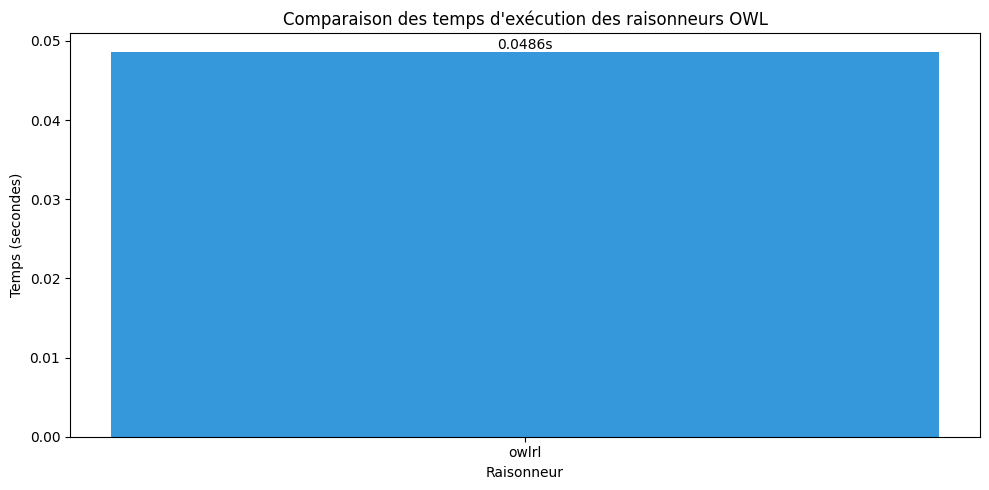

In [18]:
# Visualisation des temps d'exécution
if len(results) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    x = range(len(df))
    bars = ax.bar(x, df["Temps (s)"], color=["#3498db", "#e74c3c", "#2ecc71", "#9b59b6"][:len(df)])
    
    ax.set_xlabel("Raisonneur")
    ax.set_ylabel("Temps (secondes)")
    ax.set_title("Comparaison des temps d'exécution des raisonneurs OWL")
    ax.set_xticks(x)
    ax.set_xticklabels(df["Raisonneur"])
    
    # Ajouter les valeurs sur les barres
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{height:.4f}s",
                ha="center", va="bottom")
    
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de données pour le graphique")

In [19]:
# Comparaison des triples inférés (RL uniquement)
rl_results = [r for r in results if r["OWL Profile"] == "RL" and r["Inférés"] is not None]

if len(rl_results) >= 2:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    names = [r["Raisonneur"] for r in rl_results]
    inferred = [r["Inférés"] for r in rl_results]
    
    x = range(len(names))
    bars = ax.bar(x, inferred, color="#3498db")
    
    ax.set_xlabel("Raisonneur")
    ax.set_ylabel("Nombre de triples inférés")
    ax.set_title("Triples inférés par raisonneur (OWL 2 RL)")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{int(height)}",
                ha="center", va="bottom")
    
    plt.tight_layout()
    plt.show()
else:
    print("Pas assez de données RL pour la comparaison")

Pas assez de données RL pour la comparaison


### Analyse comparative

**Performances**:
- Les implémentations compilées (Rust, C) sont généralement plus rapides que Python pur
- HermiT (Java) offre un excellent compromis pour OWL 2 DL complet

**Couverture fonctionnelle**:
- owlrl: OWL 2 RL, intégration RDFLib native
- HermiT: OWL 2 DL complet, plus expressif
- reasonable: OWL 2 RL, performance Rust
- Growl: OWL 2 RL, vérification formelle

**Facilité d'intégration**:
- owlrl: ⭐⭐⭐⭐⭐ (pip install, natif RDFLib)
- reasonable: ⭐⭐⭐⭐ (pip install)
- OWLReady2: ⭐⭐⭐ (nécessite Java)
- Growl: ⭐ (compilation manuelle)

## Exercices

### Exercice 1: Ontologie plus grande

Téléchargez une ontologie plus grande (ex: GO, SNOMED CT ou la Pizza Ontology complète) et comparez les temps d'exécution.

```python
# Exemple avec la Pizza Ontology
g_pizza = Graph()
g_pizza.parse("https://protege.stanford.edu/ontologies/pizza/pizza.owl", format="xml")
print(f"Triples: {len(g_pizza)}")

# Mesurer le temps pour chaque raisonneur...
```

### Exercice 2: Comparaison des inférences

Les raisonneurs RL devraient produire les mêmes résultats. Vérifiez si c'est le cas:

```python
# Comparer owlrl et reasonable
set_owlrl = set(g_owlrl)
set_reasonable = set(g_reasonable)

print(f"Uniques à owlrl: {len(set_owlrl - set_reasonable)}")
print(f"Uniques à reasonable: {len(set_reasonable - set_owlrl)}")
```

### Exercice 3: Profilage avancé

Utilisez `cProfile` pour identifier les goulots d'étranglement:

```python
import cProfile
cProfile.run('owlrl.DeductiveClosure(owlrl.OWLRL_Semantics).expand(g_owlrl)')
```

## Conclusion

### Résumé des compromis

| Critère | owlrl | HermiT (OWLReady2) | reasonable | Growl |
|---------|-------|-------------------|------------|-------|
| **Facilité installation** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐ |
| **Performance** | ⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Expressivité** | RL | DL | RL | RL |
| **Intégration Python** | Native | Bridge | Native | CLI |

### Recommandations

- **Prototype rapide**: owlrl (pas d'installation, intégré à RDFLib)
- **Production Python**: reasonable (performance Rust, installation simple)
- **OWL 2 DL complet**: HermiT via OWLReady2
- **Systèmes critiques**: Growl (vérification formelle)

### Ressources

- [W3C OWL 2 RL](https://www.w3.org/TR/owl2-rl/)
- [owlrl documentation](https://owl-rl.readthedocs.io/)
- [OWLReady2](https://owlready2.readthedocs.io/)
- [HermiT reasoner](https://github.com/phileas-hermiT/hermit)
- [reasonable](https://github.com/jekyllandre/reasonable)
- [Growl](https://github.com/S-Toby-Jacobs/growl)

---

**Navigation** : [<< 13-GraphRAG](SW-13-GraphRAG.ipynb) | [Index](README.md)